In [74]:
!pip install anaflow

In [75]:
import numpy as np
import sympy as sp
import anaflow
import pandas as pd
import scipy.special as sc
from scipy import integrate
import matplotlib.pyplot as plt
from mpmath import *
mp.dps = 15; mp.pretty = True

##Задача (Uniform Flux)
###Рассмотрим неустановившейся приток к вертикальной трещине, частично вскрывающей пласт на глубину по вертикале hf и по горизонтали 2xf в бесконечном неоднородном горизонтальном пласте постоянной толщины h с начальным давлением pi, с непроницаемыми верхней и нижней границами.

###Исходные данные

In [76]:
#Исходные данные
q = 0.00092 # [m3/c] - дебит скважины
B = 1.25 # [m3/m3] - объемный коэффициент
k = 5*1e-15 # [m2] - изотропная проницаемость
h = 9.144 # [m] - толщина пласта
f = 0.3 # [] - пористость
c = 1.47*1e-9 # [1/Pa] - сжимаемость флюида
cf = 1 * 1e-9 # [1/Pa] - сжимаемость породы
ct = (c + cf) # [1/Pa] - общая породы
rw = 0.1524 # [m] - радиус ствола скважины
r = 0.1524 # [m] - радиальная координата и расстояние
mu = 3*1e-3 # [Pa*c] - вязкость
eta = k / (mu * f * ct) # коэф пьезопроводности 
eta_x = (eta ** 2 * 10) ** (1/2) # [] - коэффициент пьезопроводности в x направлении
eta_y = eta_x # [] - коэффициент пьезопроводности в y направлении
eta_z = 0.1 * eta_x # [] - коэффициент пьезопроводности в z направлении
x = rw # [m] - расстояние в x направлении
x_s = 0 # [m] - координата источника в x направлении
y = 0 # [m] - расстояние в y направлении
y_s = 0 # [m] - координата источника в y направлении
z = 5 # [m] - расстояние в z направлении
z_w = 5 # [m] - координата скважины в z направлении
t_s = 5
tau = np.logspace(0,6,100) # [c] - время
t = np.logspace(2,9,1000) # [c] - время
h_f = h # - [м] - высота трещины (вертикально вскрывающей пласт)
xf = 200 # - [м] - полудлина трещины 
x = x_w = 0
y = y_w = 0
tetta = 0
x_wd = 0
y_wd = 0
l = rw
x_d = 1
y_d = 0

In [77]:
def td_2_t(td, eta = eta, l = l):
  return l ** 2 * td / eta

In [78]:
def hd(h = h, k = k, kz = 1 * k, l = l):
  return h * (k / kz) ** 0.5 / l

In [79]:
def func_vert_grp_well(s, a ,  hd = hd(), x_d = 1, x_wd = x_wd, y_d = y_d, y_wd = y_wd, k = k, kx = k):
  return sc.kn(0, ((x_d - x_wd - a * (k / kx) ** 0.5) ** 2 + (y_d - y_wd) ** 2) ** 0.5 * s ** 0.5) 

In [80]:
def vert_grp_well(s,  hd = hd(), xf = xf, q = q, B = B, k = k):
  v = np.zeros(len(s))
  m = 0
  for i in s:
    an = np.linspace(-(xf/l), (xf/l), 100)
    v[m] = integrate.simps(func_vert_grp_well(i, an), an)
    m += 1

  return  q * mu * B / (4 * np.pi * k * xf * hd * s  ) * v

In [81]:
def func_vert_grp_well_1(s,rd_s, a = 0 , rd=rw/l,  tetta = tetta):
  return sc.kn(0, (rd ** 2 + rd_s ** 2 - 2 * rd * rd_s * np.cos(tetta-a)) ** 0.5 * s ** 0.5) 

In [82]:
def func_vert_grp_well_2(s, rd_s, a = 0, rd=rw/l, tetta = tetta):
  return sc.kn(0, (rd ** 2 + rd_s ** 2 - 2 * rd * rd_s * np.cos(tetta-a-np.pi)) ** 0.5 * s ** 0.5) 

In [83]:
def vert_grp_well_12(s, rd=rw/l, hd = hd(), xf = xf, q = q, mu = mu, B = B, k = k):
  v = np.zeros(1200)
  m = 0
  for i in s:
    an = np.linspace(0, (xf/l), 100)
    v[m] = integrate.simps(func_vert_grp_well_1(i, an), an) + integrate.simps(func_vert_grp_well_2(i, an), an)
    m += 1

  return  q * mu * B / (4 * np.pi * k  * hd * xf * s) * v

In [85]:
path = 'https://raw.githubusercontent.com/AvtomonovPavel/Method-of-sources/main/Examples/example_3.1.3'
df = pd.read_table(path, sep='\s+', engine = 'python')

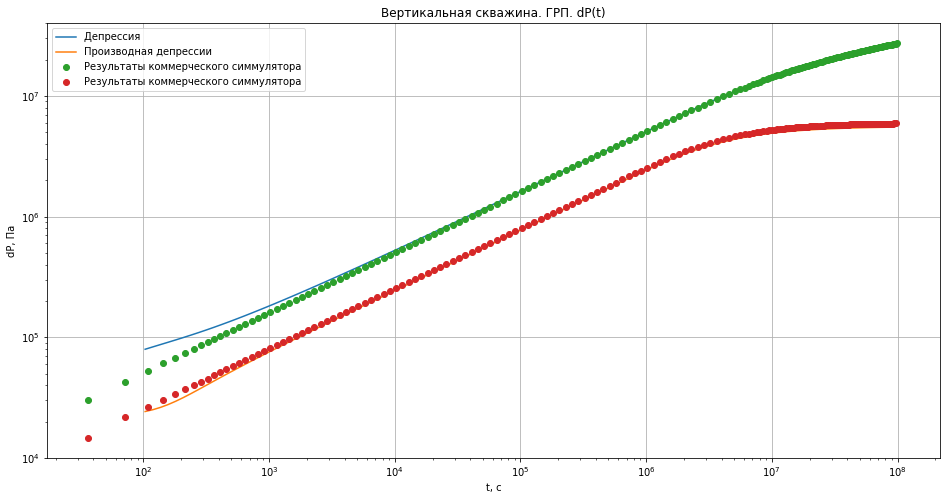

In [86]:
t = np.logspace(1, 7, 100)
fig, ax1 = plt.subplots()
fig.set_size_inches(16, 8)
pd_lps = anaflow.get_lap_inv(vert_grp_well)
pd_lps1 = anaflow.get_lap_inv(vert_grp_well_12)
ax1.plot(td_2_t(t), pd_lps1(t) , label = 'Депрессия ')
ax1.plot(td_2_t(t)[:-1], np.diff(pd_lps1(t))/np.diff(td_2_t(t)) * td_2_t(t)[:-1], label = "Производная депрессии")
plt.title("Вертикальная скважина. ГРП. dP(t)")
ax1.plot(df['dTime'], df['p-p@dt=0'],'o', label = 'Результаты коммерческого симмулятора')
ax1.plot(df['dTime'], df['Derivative'],'o', label = 'Результаты коммерческого симмулятора')
ax1.set_xscale('log')
ax1.set_yscale('log')
plt.xlabel("t, c")
plt.ylabel("dP, Па")
ax1.grid()
ax1.legend()

In [87]:
 df['p-p@dt=0']

0      3.028656e+04
1      4.283166e+04
2      5.245794e+04
3      6.057312e+04
4      6.772281e+04
           ...     
174    2.667426e+07
175    2.683690e+07
176    2.699525e+07
177    2.714953e+07
178    2.729994e+07
Name: p-p@dt=0, Length: 179, dtype: float64

In [88]:
df['dTime']

0      3.600000e+01
1      7.200000e+01
2      1.080000e+02
3      1.440000e+02
4      1.800000e+02
           ...     
174    8.957662e+07
175    9.207662e+07
176    9.457662e+07
177    9.707662e+07
178    9.957662e+07
Name: dTime, Length: 179, dtype: float64